In [15]:
!pip install -U scikit-learn
import sklearn
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the dataset
df = pd.read_csv("/kaggle/input/ttswing-data/TTSWING.csv")

# Step 1: Drop irrelevant/non-numeric metadata
drop_cols = ['id', 'date', 'fileindex', 'count', 'age', 'play years', 'height', 'weight']
df_processed = df.drop(columns=drop_cols, errors='ignore')

# Step 2: Label Encode remaining categorical fields (like gender, handedness)
label_encoders = {}
for col in df_processed.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le

# Step 3: Select only motion/statistical features
motion_features = [col for col in df_processed.columns if col.startswith(('a_', 'g_', 'ax_', 'ay_', 'az_', 'gx_', 'gy_', 'gz_'))]
X_motion = df_processed[motion_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_motion)

# Optional: Convert back to DataFrame for easier inspection
X_scaled_df = pd.DataFrame(X_scaled, columns=motion_features)

# Preview final processed data
X_scaled_df.head()

,ax_mean,ay_mean,az_mean,gx_mean,gy_mean,gz_mean,ax_var,ay_var,az_var,gx_var,...,a_fft,g_fft,a_psdx,g_psdx,a_kurt,g_kurt,a_skewn,g_skewn,a_entropy,g_entropy
0,1.351754,-0.376035,-0.744045,-0.609490,0.044871,0.003479,-1.659810,-1.702728,-1.643119,-1.781548,...,6.088619,3.905517,21.463675,14.417266,-0.065684,-0.440164,-0.747104,-0.804218,1.415774,1.402594
1,0.879061,-0.571893,-0.653980,-1.188737,1.339224,1.071969,-0.502803,-0.759044,-0.070879,-1.407116,...,-0.613220,-0.695951,0.984854,0.507843,0.974665,-1.190543,-0.595356,-0.852981,1.385905,1.397255
2,-0.844522,-1.874587,0.964401,-0.573781,0.533720,0.344702,2.446573,1.439509,3.515503,-0.438341,...,-0.539420,-0.592677,0.291489,0.130647,-0.893104,-1.260997,-1.034148,-1.224430,1.466070,1.432499
3,-1.234633,-2.159769,1.659431,0.206225,0.606107,-0.208584,2.863225,1.983904,3.700098,-0.212263,...,-0.786386,-0.718547,0.036473,-0.049124,-0.921769,-1.129311,-1.123586,-1.238627,1.418017,1.444280
4,-1.484467,-2.200261,1.736175,0.341005,0.217498,0.063877,2.839163,1.952848,3.714768,-0.247836,...,-0.844546,-0.745983,-0.029830,-0.085476,-0.979831,-1.072102,-1.146676,-1.258883,1.385153,1.434327


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# VAE architecture
class VAE(nn.Module):
    def __init__(self, input_dim=34, latent_dim=10):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)
        # Decoder
        self.fc3 = nn.Linear(latent_dim, 32)
        self.fc4 = nn.Linear(32, 64)
        self.fc5 = nn.Linear(64, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        h = F.relu(self.fc4(h))
        return self.fc5(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [17]:
# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch.optim as optim
from tqdm import tqdm
# VAE loss = reconstruction loss + KL divergence
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

# Initialize model, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim=X_scaled.shape[1], latent_dim=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 50
model.train()
for epoch in range(epochs):
    total_loss = 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
    
    for batch in loop:
        x_batch = batch[0].to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x_batch)
        loss = vae_loss(recon_batch, x_batch, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(X_scaled)
    print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}")


Epoch 1/50: 100%|██████████| 761/761 [00:02<00:00, 259.83it/s, loss=1.09e+3]


Epoch 1, Avg Loss: 16.1082


Epoch 2/50: 100%|██████████| 761/761 [00:02<00:00, 264.03it/s, loss=972]    


Epoch 2, Avg Loss: 13.8927


Epoch 3/50: 100%|██████████| 761/761 [00:02<00:00, 266.07it/s, loss=908]    


Epoch 3, Avg Loss: 13.5599


Epoch 4/50: 100%|██████████| 761/761 [00:02<00:00, 264.27it/s, loss=907]    


Epoch 4, Avg Loss: 13.2741


Epoch 5/50: 100%|██████████| 761/761 [00:02<00:00, 266.40it/s, loss=844]    


Epoch 5, Avg Loss: 13.1927


Epoch 6/50: 100%|██████████| 761/761 [00:03<00:00, 249.78it/s, loss=974]    


Epoch 6, Avg Loss: 13.1070


Epoch 7/50: 100%|██████████| 761/761 [00:02<00:00, 265.58it/s, loss=994]    


Epoch 7, Avg Loss: 13.1100


Epoch 8/50: 100%|██████████| 761/761 [00:02<00:00, 267.52it/s, loss=994]    


Epoch 8, Avg Loss: 13.3226


Epoch 9/50: 100%|██████████| 761/761 [00:02<00:00, 263.19it/s, loss=925]    


Epoch 9, Avg Loss: 12.9675


Epoch 10/50: 100%|██████████| 761/761 [00:02<00:00, 267.23it/s, loss=1.06e+3]


Epoch 10, Avg Loss: 13.0582


Epoch 11/50: 100%|██████████| 761/761 [00:02<00:00, 268.97it/s, loss=865]    


Epoch 11, Avg Loss: 13.3137


Epoch 12/50: 100%|██████████| 761/761 [00:02<00:00, 267.47it/s, loss=1.03e+3]


Epoch 12, Avg Loss: 13.0480


Epoch 13/50: 100%|██████████| 761/761 [00:02<00:00, 267.45it/s, loss=941]    


Epoch 13, Avg Loss: 12.9244


Epoch 14/50: 100%|██████████| 761/761 [00:02<00:00, 269.73it/s, loss=941]    


Epoch 14, Avg Loss: 12.9629


Epoch 15/50: 100%|██████████| 761/761 [00:02<00:00, 271.86it/s, loss=899]    


Epoch 15, Avg Loss: 12.9522


Epoch 16/50: 100%|██████████| 761/761 [00:02<00:00, 267.91it/s, loss=842]    


Epoch 16, Avg Loss: 13.0297


Epoch 17/50: 100%|██████████| 761/761 [00:03<00:00, 252.42it/s, loss=865]    


Epoch 17, Avg Loss: 12.9162


Epoch 18/50: 100%|██████████| 761/761 [00:02<00:00, 265.41it/s, loss=881]    


Epoch 18, Avg Loss: 13.1157


Epoch 19/50: 100%|██████████| 761/761 [00:02<00:00, 269.28it/s, loss=934]    


Epoch 19, Avg Loss: 12.9452


Epoch 20/50: 100%|██████████| 761/761 [00:02<00:00, 265.44it/s, loss=892]    


Epoch 20, Avg Loss: 13.0792


Epoch 21/50: 100%|██████████| 761/761 [00:02<00:00, 269.22it/s, loss=856]    


Epoch 21, Avg Loss: 12.8469


Epoch 22/50: 100%|██████████| 761/761 [00:02<00:00, 268.64it/s, loss=908]    


Epoch 22, Avg Loss: 13.0556


Epoch 23/50: 100%|██████████| 761/761 [00:02<00:00, 264.63it/s, loss=830]    


Epoch 23, Avg Loss: 12.9506


Epoch 24/50: 100%|██████████| 761/761 [00:02<00:00, 268.12it/s, loss=1.02e+3]


Epoch 24, Avg Loss: 13.3424


Epoch 25/50: 100%|██████████| 761/761 [00:02<00:00, 272.51it/s, loss=858]    


Epoch 25, Avg Loss: 12.9724


Epoch 26/50: 100%|██████████| 761/761 [00:02<00:00, 267.82it/s, loss=1.06e+3]


Epoch 26, Avg Loss: 13.0167


Epoch 27/50: 100%|██████████| 761/761 [00:02<00:00, 262.88it/s, loss=954]    


Epoch 27, Avg Loss: 13.1093


Epoch 28/50: 100%|██████████| 761/761 [00:03<00:00, 251.79it/s, loss=849]    


Epoch 28, Avg Loss: 12.8552


Epoch 29/50: 100%|██████████| 761/761 [00:02<00:00, 267.27it/s, loss=858]    


Epoch 29, Avg Loss: 12.8451


Epoch 30/50: 100%|██████████| 761/761 [00:02<00:00, 264.02it/s, loss=974]    


Epoch 30, Avg Loss: 12.8852


Epoch 31/50: 100%|██████████| 761/761 [00:02<00:00, 267.23it/s, loss=845]    


Epoch 31, Avg Loss: 12.8330


Epoch 32/50: 100%|██████████| 761/761 [00:02<00:00, 266.62it/s, loss=940]    


Epoch 32, Avg Loss: 12.8439


Epoch 33/50: 100%|██████████| 761/761 [00:02<00:00, 265.79it/s, loss=863]    


Epoch 33, Avg Loss: 12.8830


Epoch 34/50: 100%|██████████| 761/761 [00:02<00:00, 266.81it/s, loss=926]    


Epoch 34, Avg Loss: 12.8409


Epoch 46/50: 100%|██████████| 761/761 [00:02<00:00, 269.55it/s, loss=884]    


Epoch 46, Avg Loss: 12.7909


Epoch 47/50: 100%|██████████| 761/761 [00:02<00:00, 272.24it/s, loss=799]    


Epoch 47, Avg Loss: 12.9393


Epoch 48/50: 100%|██████████| 761/761 [00:02<00:00, 268.45it/s, loss=937]    


Epoch 48, Avg Loss: 12.8411


Epoch 49/50: 100%|██████████| 761/761 [00:02<00:00, 275.89it/s, loss=798]    


Epoch 49, Avg Loss: 12.7681


Epoch 50/50: 100%|██████████| 761/761 [00:02<00:00, 264.32it/s, loss=787]    

Epoch 50, Avg Loss: 12.8756


In [20]:
import numpy as np

model.eval()

# Number of synthetic samples to generate
n_samples = 10

# Sample from standard normal (latent space)
z = torch.randn(n_samples, 10).to(device)

# Decode into synthetic swing features
with torch.no_grad():
    synthetic_swings = model.decode(z).cpu().numpy()

# Convert to DataFrame for inspection
import pandas as pd
synthetic_df = pd.DataFrame(synthetic_swings, columns=motion_features)
print(synthetic_df.head())

    ax_mean   ay_mean   az_mean   gx_mean   gy_mean   gz_mean    ax_var  \
0  1.091458  0.010509 -0.566257 -0.533577  0.774876  0.188579 -0.902277   
1 -0.963207  2.359711  2.217272 -0.900598  0.027062  0.305973  0.654507   
2  0.325604  0.577930  0.041318 -0.506045 -0.041556  0.069559 -0.185318   
3  0.499785  0.440998 -0.585458 -0.609949  0.333201  0.170572 -0.127566   
4 -0.418053  0.847295  0.563853 -0.774107 -0.969672 -0.390836  0.221725   

     ay_var    az_var    gx_var  ...     a_fft     g_fft    a_psdx    g_psdx  \
0 -0.710182 -0.738487 -0.535408  ...  0.129399 -0.072304  0.111938 -0.563500   
1  1.086866  3.725575  4.472165  ... -0.313584 -0.339703 -0.216756 -0.297042   
2 -0.162959 -0.118286  0.089158  ... -0.107972 -0.064547 -0.162782 -0.111649   
3 -0.127401 -0.172726 -0.218309  ... -0.014631  0.007258 -0.160741 -0.087814   
4  0.400314  0.346328  1.344053  ... -0.236197 -0.222576 -0.140443 -0.157997   

     a_kurt    g_kurt   a_skewn   g_skewn  a_entropy  g_entropy  
0 

/usr/local/lib/python3.11/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


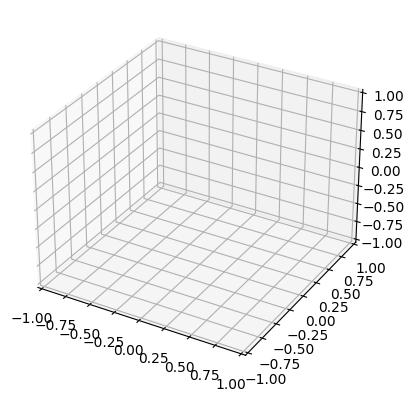

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# Example data (replace with your actual ax, ay, az, gx, gy, gz data)
num_frames = 100  # Number of data points
time = np.linspace(0, 10, num_frames)  # Simulate a 10-second period

# Generate synthetic data for ax, ay, az (acceleration) and gx, gy, gz (angular velocity)
ax = np.sin(time)
ay = np.cos(time)
az = np.sin(0.5 * time)
gx = np.cos(time)
gy = np.sin(time)
gz = np.cos(0.5 * time)

# Initial hand position, ensuring it's treated as a float array
hand_position = np.array([0.0, 0.0, 0.0], dtype=np.float64)

# Create the figure for the 3D plot
fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Set the limits of the plot
ax3d.set_xlim([-1, 1])
ax3d.set_ylim([-1, 1])
ax3d.set_zlim([-1, 1])

# Create a point for the hand
hand_point, = ax3d.plot([], [], [], 'bo', markersize=10)

# Update function for the animation
def update(frame):
    global hand_position
    
    # Simulate the hand movement based on acceleration
    acceleration = np.array([ax[frame], ay[frame], az[frame]], dtype=np.float64)
    
    # Update the hand's position by adding the acceleration (scaled)
    hand_position += acceleration * 0.1  # Scaling factor for movement
    
    # Simulate rotation based on angular velocity (using simple Euler integration)
    rotation_matrix = np.array([
        [1, -gz[frame] * 0.1, gy[frame] * 0.1],
        [gz[frame] * 0.1, 1, -gx[frame] * 0.1],
        [-gy[frame] * 0.1, gx[frame] * 0.1, 1]
    ], dtype=np.float64)
    
    # Rotate the hand position
    hand_position = np.dot(rotation_matrix, hand_position)
    
    # Update the hand's position in the plot
    hand_point.set_data(hand_position[0], hand_position[1])
    hand_point.set_3d_properties(hand_position[2])
    
    return hand_point,

# Create the animation
ani = FuncAnimation(fig, update, frames=num_frames, interval=100)

# Show the plot with animation
plt.show()
